I am treating this project as one with modules and seperate files that is why you will see me importing modules again in each section

### Installing Libraries

In [8]:
!pip install --quiet pandas numpy scikit-learn xgboost matplotlib shap requests openpyxl

In [23]:
!pip install --quiet streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


In [ ]:
!pip install --quiet selenium requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nv

In [24]:
!pip install prophet

### Importing Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/DayAheadSolar/{data,notebooks,src,outputs}

In [2]:
BASE = "/content/drive/MyDrive/DayAheadSolar"

## Data Setup (Solar)

### Downlaod solar output data from CEA using Selenium

In [ ]:
!apt-get update > /dev/null
!apt install chromium-chromedriver -y > /dev/null
!pip install --quiet selenium
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0, '/usr/lib/chromium-browser/')

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


In [ ]:
from selenium.webdriver.common.keys import Keys

driver = webdriver.Chrome(options=options)
driver.get("https://cea.nic.in/daily-renewable-generation-report/?lang=en")
wait = WebDriverWait(driver, 20)

# Let page load completely
time.sleep(8)

# Apply date filters
driver.find_element(By.ID, "min").send_keys("01/06/2023")
driver.find_element(By.ID, "max").send_keys("31/05/2025")
driver.find_element(By.ID, "max").send_keys(Keys.RETURN)  # Trigger filter

time.sleep(2)

# Select "All" from records dropdown
select = Select(driver.find_element(By.NAME, "table_length"))
select.select_by_value("-1")
time.sleep(2)

# Wait until at least one Excel icon appears
wait.until(EC.presence_of_element_located((By.XPATH, '//a[@title="Download Report in Excel Format"]')))

# Now collect all links
links = driver.find_elements(By.XPATH, '//a[@title="Download Report in Excel Format"]')
excel_hrefs = [link.get_attribute("href") for link in links]

driver.quit()

print(f"✅ Extracted {len(excel_hrefs)} Excel links.")


✅ Extracted 1648 Excel links.


In [ ]:
import pandas as pd

df_links = pd.DataFrame({"url": excel_hrefs})
df_links.to_csv("/content/drive/MyDrive/DayAheadSolar/data/raw/cea_links.csv", index=False)
df_links.head()

,url
0,https://cea.nic.in/wp-content/uploads/daily_re...
1,https://cea.nic.in/wp-content/uploads/daily_re...
2,https://cea.nic.in/wp-content/uploads/daily_re...
3,https://cea.nic.in/wp-content/uploads/daily_re...
4,https://cea.nic.in/wp-content/uploads/daily_re...


Not sure why the date filter wasn't applied, hence I manually deleted the rows to get the links from 1 June 2023 to 31 May 2025, moving to file downloading, and added a date_str

In [ ]:
import os
import pandas as pd
import requests
from tqdm import tqdm
import time

# Paths
csv_path = "/content/drive/MyDrive/DayAheadSolar/data/raw/filtered_links.csv"
download_dir = "/content/drive/MyDrive/DayAheadSolar/data/raw/cea_reports"
os.makedirs(download_dir, exist_ok=True)

# Load filtered links
df = pd.read_csv(csv_path)
print(f"📄 Found {len(df)} filtered links to download.")

# Use 'url' and 'date_str' columns
required_cols = {"url", "date_str"}
if not required_cols.issubset(set(df.columns)):
    raise ValueError(f"CSV must contain columns: {required_cols}")

# Track failed files
failed_downloads = []

# Download each file
for i, row in tqdm(df.iterrows(), total=len(df), desc="Downloading XLSX files"):
    url = row["url"]
    date_str = row["date_str"]  # should be YYYY-MM-DD
    filename = f"{date_str}.xlsx"
    filepath = os.path.join(download_dir, filename)

    success = False
    for attempt in range(3):  # retry up to 3 times
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                with open(filepath, "wb") as f:
                    f.write(response.content)
                success = True
                break
            else:
                print(f"⚠️ {date_str} → Status {response.status_code} (attempt {attempt+1})")
        except Exception as e:
            print(f"⚠️ {date_str} → Error: {e} (attempt {attempt+1})")
        time.sleep(1.5)  # brief pause before retry

    if not success:
        failed_downloads.append((date_str, url))

# Log failed downloads
if failed_downloads:
    print("\n❌ Failed to download the following files after retries:")
    for date_str, url in failed_downloads:
        print(f"- {date_str} → {url}")
else:
    print("\n✅ All files downloaded successfully!")


📄 Found 731 filtered links to download.


⚠️ 2025-05-31 → Error: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')) (attempt 1)



✅ All files downloaded successfully!


### Consolidating Solar Outputs data

In [ ]:
import pandas as pd
import os
from tqdm import tqdm

# === SETUP ===
data_dir = '/content/drive/MyDrive/DayAheadSolar/data/raw/cea_reports'
out_dir = '/content/drive/MyDrive/DayAheadSolar/data/processed'
os.makedirs(out_dir, exist_ok=True)

files = sorted([f for f in os.listdir(data_dir) if f.endswith('.xlsx')])

# === OUTPUT LIST ===
state_records = []

for filename in tqdm(files, desc="Processing files"):
    file_path = os.path.join(data_dir, filename)
    date = filename.replace('.xlsx', '')
    record = {'date': date}

    try:
        xl = pd.ExcelFile(file_path)
        sheet_names = [s.strip().lower() for s in xl.sheet_names]

        # === DYNAMIC COLUMN INDEX BASED ON DATE ===
        from datetime import datetime
        file_date = datetime.strptime(date, "%Y-%m-%d")
        format_change_date = datetime(2024, 7, 1)

        if file_date >= format_change_date:
            state_col, value_col = 0, 2
            isgs_col_name, isgs_value_col = 0, 6
        else:
            state_col, value_col = 1, 3
            isgs_col_name, isgs_value_col = 1, 7  # plant-wise sheet removed anyway

        # === GENERATION SHEET ===
        gen_sheet = next((s for s in xl.sheet_names if s.strip().lower() == 'generation'), None)
        if gen_sheet:
            try:
                df_gen = xl.parse(gen_sheet, header=None)
                gen_row = df_gen[df_gen[state_col].astype(str).str.contains('Rajasthan', case=False, na=False)]
                record['gen_solar_mu'] = float(gen_row.iloc[0, value_col]) if not gen_row.empty else None
            except Exception as e:
                print(f"⚠️  {filename}: error in Generation sheet - {e}")

        # === STATE-WISE / STATE CARE SHEET ===
        sc_sheet = next((s for s in xl.sheet_names if 'state' in s.strip().lower()), None)
        if sc_sheet:
            try:
                df_sc = xl.parse(sc_sheet, header=None)
                sc_row = df_sc[df_sc[state_col].astype(str).str.contains('Rajasthan', case=False, na=False)]
                record['statecare_solar_mu'] = float(sc_row.iloc[0, value_col]) if not sc_row.empty else None
            except Exception as e:
                print(f"⚠️  {filename}: error in State sheet - {e}")

        state_records.append(record)

    except Exception as e:
        print(f"❌ Failed {filename} → {e}")

# === SAVE STATE-WISE OUTPUT ONLY ===
pd.DataFrame(state_records).to_csv(os.path.join(out_dir, 'solar_state.csv'), index=False)

print("✅ Finished processing and saved CSV.")

Processing files: 100%|██████████| 731/731 [00:49<00:00, 14.86it/s]


✅ Finished processing and saved CSV.


We finally have two consolidated files with solar generation data. One for the entire state of Rajasthan nd the other for two stations of Bhadla Plant.

### Preprocessing Solar Data

In [ ]:
# 📦 Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
%matplotlib inline

# 🔽 Load Data
dfsolar = pd.read_csv('/content/drive/MyDrive/DayAheadSolar/data/processed/solar_state.csv')
print("✅ Loaded data with shape:", dfsolar.shape)
dfsolar.head()

✅ Loaded data with shape: (731, 3)


,date,gen_solar_mu,statecare_solar_mu
0,2023-06-01,95.31,21.66
1,2023-06-02,110.25,25.83
2,2023-06-03,110.43,24.83
3,2023-06-04,120.77,27.36
4,2023-06-05,112.97,26.30


In [ ]:
# 🧹 Preprocessing: Parse date, extract temporal features
dfsolar['date'] = pd.to_datetime(dfsolar['date'], errors='coerce')
dfsolar = dfsolar.dropna(subset=['date'])  # Drop rows where date parsing failed

dfsolar['year'] = dfsolar['date'].dt.year
dfsolar['month'] = dfsolar['date'].dt.month
dfsolar['day'] = dfsolar['date'].dt.day
dfsolar['day_of_week'] = dfsolar['date'].dt.day_name()

print("✅ Date column parsed and temporal features extracted")
dfsolar.head()

✅ Date column parsed and temporal features extracted


,date,gen_solar_mu,statecare_solar_mu,year,month,day,day_of_week
0,2023-06-01,95.31,21.66,2023,6,1,Thursday
1,2023-06-02,110.25,25.83,2023,6,2,Friday
2,2023-06-03,110.43,24.83,2023,6,3,Saturday
3,2023-06-04,120.77,27.36,2023,6,4,Sunday
4,2023-06-05,112.97,26.30,2023,6,5,Monday


In [ ]:
# 📈 Correlation Analysis between Gen and StateCare
corr = dfsolar[['gen_solar_mu', 'statecare_solar_mu']].corr().iloc[0, 1]
mae = mean_absolute_error(dfsolar['gen_solar_mu'], dfsolar['statecare_solar_mu'])
rmse = mean_squared_error(dfsolar['gen_solar_mu'], dfsolar['statecare_solar_mu'])

metrics = pd.DataFrame({
    'Metric': ['Correlation', 'MAE (MU)', 'RMSE (MU)'],
    'Value': [corr, mae, rmse]
})

print("📊 Gen vs StateCare – Metrics")
display(metrics)

📊 Gen vs StateCare – Metrics


,Metric,Value
0,Correlation,0.972158
1,MAE (MU),100.720260
2,RMSE (MU),10833.996689


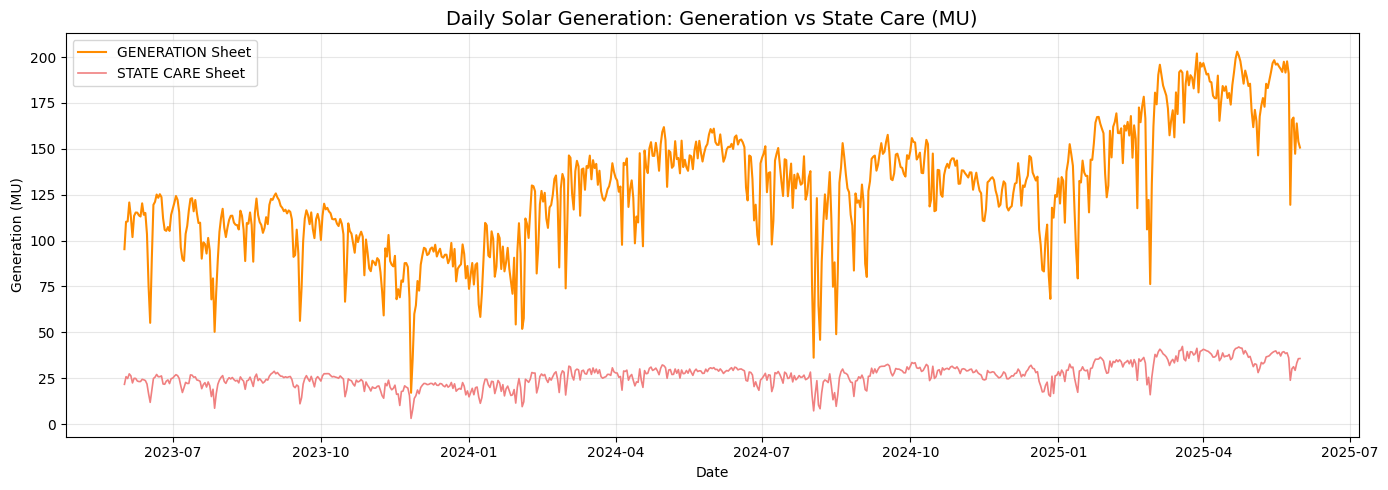

In [ ]:
# 📊 Plot both columns to visualize relationship
plt.figure(figsize=(14, 5))
plt.plot(dfsolar['date'], dfsolar['gen_solar_mu'], label='GENERATION Sheet', linewidth=1.5, color='darkorange')
plt.plot(dfsolar['date'], dfsolar['statecare_solar_mu'], label='STATE CARE Sheet', linewidth=1.2, color='lightcoral')
plt.legend()
plt.title('Daily Solar Generation: Generation vs State Care (MU)', fontsize=14)
plt.ylabel('Generation (MU)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ⚙️ Final: Convert to MWh and drop original columns
dfsolar['solar_mwh'] = dfsolar['gen_solar_mu'] * 1000  # Convert MU to MWh

# Drop unused MU columns
dfsolar.drop(columns=['gen_solar_mu', 'statecare_solar_mu'], inplace=True)

# 📁 Save the cleaned file
cleaned_path = '/content/drive/MyDrive/DayAheadSolar/data/processed/solar_clean.csv'
dfsolar.to_csv(cleaned_path, index=False)
print(f"✅ Cleaned dataset saved to: {cleaned_path}")

✅ Cleaned dataset saved to: /content/drive/MyDrive/DayAheadSolar/data/processed/solar_clean.csv


## Data Setup (Climate)

### Download climate data from NASA POWER using API access

In [ ]:
import requests
import pandas as pd

# === 1. Coordinates and time range ===
lat, lon = 26.9, 75.8
start = "2023-06-01"
end = "2025-05-31"

# === 2. NASA POWER API request ===
url = (
    f"https://power.larc.nasa.gov/api/temporal/daily/point"
    f"?start={start.replace('-', '')}&end={end.replace('-', '')}"
    f"&latitude={lat}&longitude={lon}"
    f"&parameters=T2M,T2M_MAX,T2M_MIN,RH2M,WS2M,PRECTOTCORR,"
    f"ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN"
    f"&community=RE&format=JSON"
)

response = requests.get(url)
data = response.json()

# === 3. Extract parameters ===
params = data['properties']['parameter']

# === 4. Convert each param to dataframe ===
dfs = []
for param, values in params.items():
    df_param = pd.DataFrame(values.items(), columns=['date', param])
    dfs.append(df_param)

# === 5. Merge all parameter dataframes on 'date' ===
dfclim = dfs[0]
for other in dfs[1:]:
    dfclim = dfclim.merge(other, on='date')

# === 6. Format date ===
dfclim['date'] = pd.to_datetime(dfclim['date'], format='%Y%m%d')

# === 7. Save final dataframe ===
out_path = '/content/drive/MyDrive/DayAheadSolar/data/processed/climate_nasa_power.csv'
dfclim.to_csv(out_path, index=False)
print(f"✅ Saved climate data to: {out_path}")
df.head()

✅ Saved climate data to: /content/drive/MyDrive/DayAheadSolar/data/processed/climate_nasa_power.csv


,date,T2M,T2M_MAX,T2M_MIN,RH2M,WS2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN
0,2023-06-01,28.38,35.44,21.47,56.12,2.87,0.19,7.43,7.72
1,2023-06-02,29.31,35.22,22.45,55.83,2.40,0.00,6.68,7.66
2,2023-06-03,31.55,37.24,25.50,50.16,1.59,0.01,7.15,7.60
3,2023-06-04,30.56,35.28,25.89,53.07,2.64,0.03,5.89,7.26
4,2023-06-05,31.41,37.95,24.30,43.57,1.97,0.00,7.98,8.01


### Preprocessing climate data

In [ ]:
import pandas as pd

# Load NASA POWER climate data
climate_path = '/content/drive/MyDrive/DayAheadSolar/data/processed/climate_nasa_power.csv'
dfclim = pd.read_csv(climate_path, parse_dates=['date'])

# Rename climate columns
dfclim = dfclim.rename(columns={
    "T2M": "temp_avg_c",
    "T2M_MAX": "temp_max_c",
    "T2M_MIN": "temp_min_c",
    "RH2M": "humidity_pct",
    "WS2M": "wind_speed_ms",
    "PRECTOTCORR": "precip_mm",
    "ALLSKY_SFC_SW_DWN": "solar_rad_allsky_mj_m2",
    "CLRSKY_SFC_SW_DWN": "solar_rad_clrsky_mj_m2"
})

# Preview renamed columns
dfclim.head()

,date,temp_avg_c,temp_max_c,temp_min_c,humidity_pct,wind_speed_ms,precip_mm,solar_rad_allsky_mj_m2,solar_rad_clrsky_mj_m2
0,2023-06-01,28.38,35.44,21.47,56.12,2.87,0.19,7.43,7.72
1,2023-06-02,29.31,35.22,22.45,55.83,2.40,0.00,6.68,7.66
2,2023-06-03,31.55,37.24,25.50,50.16,1.59,0.01,7.15,7.60
3,2023-06-04,30.56,35.28,25.89,53.07,2.64,0.03,5.89,7.26
4,2023-06-05,31.41,37.95,24.30,43.57,1.97,0.00,7.98,8.01


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select numeric columns to normalize
climate_numeric = [
    'temp_avg_c', 'temp_max_c', 'temp_min_c',
    'humidity_pct', 'wind_speed_ms', 'precip_mm',
    'solar_rad_allsky_mj_m2', 'solar_rad_clrsky_mj_m2'
]

# Initialize scaler and fit-transform
scaler = MinMaxScaler()
norm_values = scaler.fit_transform(dfclim[climate_numeric])
dfclim_norm = pd.DataFrame(norm_values, columns=[col + "_norm" for col in climate_numeric])

# Combine normalized with original
dfclim_final = pd.concat([dfclim, dfclim_norm], axis=1)
dfclim_final.head()

,date,temp_avg_c,temp_max_c,temp_min_c,humidity_pct,wind_speed_ms,precip_mm,solar_rad_allsky_mj_m2,solar_rad_clrsky_mj_m2,temp_avg_c_norm,temp_max_c_norm,temp_min_c_norm,humidity_pct_norm,wind_speed_ms_norm,precip_mm_norm,solar_rad_allsky_mj_m2_norm,solar_rad_clrsky_mj_m2_norm
0,2023-06-01,28.38,35.44,21.47,56.12,2.87,0.19,7.43,7.72,0.618593,0.587217,0.577778,0.574903,0.451923,0.001832,0.999355,0.999404
1,2023-06-02,29.31,35.22,22.45,55.83,2.40,0.00,6.68,7.66,0.651467,0.579893,0.610774,0.571576,0.361538,0.000000,0.998610,0.999345
2,2023-06-03,31.55,37.24,25.50,50.16,1.59,0.01,7.15,7.60,0.730647,0.647137,0.713468,0.506538,0.205769,0.000096,0.999077,0.999285
3,2023-06-04,30.56,35.28,25.89,53.07,2.64,0.03,5.89,7.26,0.695652,0.581891,0.726599,0.539917,0.407692,0.000289,0.997825,0.998948
4,2023-06-05,31.41,37.95,24.30,43.57,1.97,0.00,7.98,8.01,0.725698,0.670772,0.673064,0.430947,0.278846,0.000000,0.999901,0.999692


In [ ]:
climate_clean_path = '/content/drive/MyDrive/DayAheadSolar/data/processed/climate_clean.csv'
dfclim_final.to_csv(climate_clean_path, index=False)
print(f"✅ Climate data saved to: {climate_clean_path}")

✅ Climate data saved to: /content/drive/MyDrive/DayAheadSolar/data/processed/climate_clean.csv


## Merging Solar and Climate Data + EDA + PDA

### Consolidating the Database and Validating

In [ ]:
import pandas as pd

# 📁 Load cleaned solar and climate data
solar_path = '/content/drive/MyDrive/DayAheadSolar/data/processed/solar_clean.csv'
climate_path = '/content/drive/MyDrive/DayAheadSolar/data/processed/climate_clean.csv'

dfsolar = pd.read_csv(solar_path, parse_dates=['date'])
dfclim = pd.read_csv(climate_path, parse_dates=['date'])

# 🔍 Check the shape and preview
print(f"Solar data shape: {dfsolar.shape}")
print(f"Climate data shape: {dfclim.shape}")
display(dfsolar.head())
display(dfclim.head())

Solar data shape: (731, 6)
Climate data shape: (731, 17)


,date,year,month,day,day_of_week,solar_mwh
0,2023-06-01,2023,6,1,Thursday,95310.0
1,2023-06-02,2023,6,2,Friday,110250.0
2,2023-06-03,2023,6,3,Saturday,110430.0
3,2023-06-04,2023,6,4,Sunday,120770.0
4,2023-06-05,2023,6,5,Monday,112970.0


,date,temp_avg_c,temp_max_c,temp_min_c,humidity_pct,wind_speed_ms,precip_mm,solar_rad_allsky_mj_m2,solar_rad_clrsky_mj_m2,temp_avg_c_norm,temp_max_c_norm,temp_min_c_norm,humidity_pct_norm,wind_speed_ms_norm,precip_mm_norm,solar_rad_allsky_mj_m2_norm,solar_rad_clrsky_mj_m2_norm
0,2023-06-01,28.38,35.44,21.47,56.12,2.87,0.19,7.43,7.72,0.618593,0.587217,0.577778,0.574903,0.451923,0.001832,0.999355,0.999404
1,2023-06-02,29.31,35.22,22.45,55.83,2.40,0.00,6.68,7.66,0.651467,0.579893,0.610774,0.571576,0.361538,0.000000,0.998610,0.999345
2,2023-06-03,31.55,37.24,25.50,50.16,1.59,0.01,7.15,7.60,0.730647,0.647137,0.713468,0.506538,0.205769,0.000096,0.999077,0.999285
3,2023-06-04,30.56,35.28,25.89,53.07,2.64,0.03,5.89,7.26,0.695652,0.581891,0.726599,0.539917,0.407692,0.000289,0.997825,0.998948
4,2023-06-05,31.41,37.95,24.30,43.57,1.97,0.00,7.98,8.01,0.725698,0.670772,0.673064,0.430947,0.278846,0.000000,0.999901,0.999692


In [ ]:
# 🔗 Merge on 'date' column
dfmerged = pd.merge(dfsolar, dfclim, on='date', how='inner')

# 🧹 Drop any rows with missing values (optional, depending on further steps)
dfmerged.dropna(inplace=True)

# 💾 Save merged dataset
merged_path = '/content/drive/MyDrive/DayAheadSolar/data/processed/merged_solar_climate.csv'
dfmerged.to_csv(merged_path, index=False)
print(f"✅ Merged data saved to: {merged_path}")

# Preview
dfmerged.head()

✅ Merged data saved to: /content/drive/MyDrive/DayAheadSolar/data/processed/merged_solar_climate.csv


,date,year,month,day,day_of_week,solar_mwh,temp_avg_c,temp_max_c,temp_min_c,humidity_pct,...,solar_rad_allsky_mj_m2,solar_rad_clrsky_mj_m2,temp_avg_c_norm,temp_max_c_norm,temp_min_c_norm,humidity_pct_norm,wind_speed_ms_norm,precip_mm_norm,solar_rad_allsky_mj_m2_norm,solar_rad_clrsky_mj_m2_norm
0,2023-06-01,2023,6,1,Thursday,95310.0,28.38,35.44,21.47,56.12,...,7.43,7.72,0.618593,0.587217,0.577778,0.574903,0.451923,0.001832,0.999355,0.999404
1,2023-06-02,2023,6,2,Friday,110250.0,29.31,35.22,22.45,55.83,...,6.68,7.66,0.651467,0.579893,0.610774,0.571576,0.361538,0.000000,0.998610,0.999345
2,2023-06-03,2023,6,3,Saturday,110430.0,31.55,37.24,25.50,50.16,...,7.15,7.60,0.730647,0.647137,0.713468,0.506538,0.205769,0.000096,0.999077,0.999285
3,2023-06-04,2023,6,4,Sunday,120770.0,30.56,35.28,25.89,53.07,...,5.89,7.26,0.695652,0.581891,0.726599,0.539917,0.407692,0.000289,0.997825,0.998948
4,2023-06-05,2023,6,5,Monday,112970.0,31.41,37.95,24.30,43.57,...,7.98,8.01,0.725698,0.670772,0.673064,0.430947,0.278846,0.000000,0.999901,0.999692


In [ ]:
# 📈 Summary statistics
display(dfmerged.describe())

# ❓ Check for nulls
print("🔎 Null values in merged data:")
print(dfmerged.isnull().sum())

# 📅 Date range
print(f"\n📆 Date Range: {dfmerged['date'].min().date()} to {dfmerged['date'].max().date()}")

,date,year,month,day,solar_mwh,temp_avg_c,temp_max_c,temp_min_c,humidity_pct,wind_speed_ms,...,solar_rad_allsky_mj_m2,solar_rad_clrsky_mj_m2,temp_avg_c_norm,temp_max_c_norm,temp_min_c_norm,humidity_pct_norm,wind_speed_ms_norm,precip_mm_norm,solar_rad_allsky_mj_m2_norm,solar_rad_clrsky_mj_m2_norm
count,731,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,...,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2024-05-30 23:59:59.999999744,2023.913817,6.519836,15.738714,127320.793434,25.325458,32.238030,19.365472,49.942380,2.085363,...,3.547100,-171.594145,0.510621,0.480627,0.506918,0.504042,0.301031,0.022232,0.995499,0.821393
min,2023-06-01 00:00:00,2023.000000,1.000000,1.000000,17040.000000,10.880000,17.800000,4.310000,6.000000,0.520000,...,-999.000000,-999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-11-30 12:00:00,2023.000000,4.000000,8.000000,106075.000000,19.175000,27.300000,12.715000,29.995000,1.370000,...,3.815000,3.585000,0.293213,0.316245,0.282997,0.275235,0.163462,0.000000,0.995765,0.995299
50%,2024-05-31 00:00:00,2024.000000,7.000000,16.000000,126830.000000,26.820000,31.970000,21.030000,46.490000,1.860000,...,4.920000,5.280000,0.563450,0.471704,0.562963,0.464441,0.257692,0.000000,0.996862,0.996982
75%,2024-11-29 12:00:00,2024.000000,10.000000,23.000000,146705.000000,30.045000,36.280000,25.120000,70.545000,2.585000,...,6.095000,6.740000,0.677448,0.615180,0.700673,0.740365,0.397115,0.006940,0.998029,0.998431
max,2025-05-31 00:00:00,2025.000000,12.000000,31.000000,202940.000000,39.170000,47.840000,34.010000,93.180000,5.720000,...,8.080000,8.320000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,0.701828,3.451913,8.809949,32364.734324,6.883216,6.273869,7.374071,23.083874,0.937568,...,37.160092,383.279027,0.243309,0.208850,0.248285,0.264784,0.180302,0.070289,0.036899,0.380494


🔎 Null values in merged data:
date                           0
year                           0
month                          0
day                            0
day_of_week                    0
solar_mwh                      0
temp_avg_c                     0
temp_max_c                     0
temp_min_c                     0
humidity_pct                   0
wind_speed_ms                  0
precip_mm                      0
solar_rad_allsky_mj_m2         0
solar_rad_clrsky_mj_m2         0
temp_avg_c_norm                0
temp_max_c_norm                0
temp_min_c_norm                0
humidity_pct_norm              0
wind_speed_ms_norm             0
precip_mm_norm                 0
solar_rad_allsky_mj_m2_norm    0
solar_rad_clrsky_mj_m2_norm    0
dtype: int64

📆 Date Range: 2023-06-01 to 2025-05-31


### Visualizations and Basic Plots

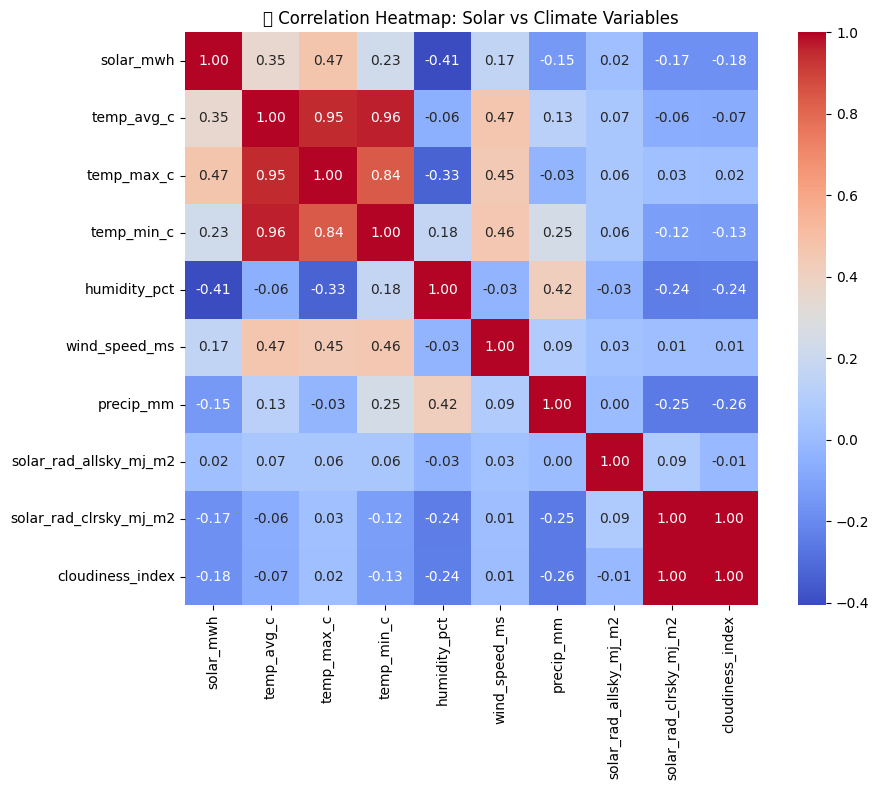

<Figure size 640x480 with 0 Axes>

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the corrected dataset
file_path = f"{BASE}/data/processed/merged_solar_climate.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

# Calculate additional feature: cloudiness proxy (diff between clear and all-sky radiation)
df['cloudiness_index'] = df['solar_rad_clrsky_mj_m2'] - df['solar_rad_allsky_mj_m2']

# Prepare correlation heatmap
corr_cols = [
    'solar_mwh', 'temp_avg_c', 'temp_max_c', 'temp_min_c', 'humidity_pct',
    'wind_speed_ms', 'precip_mm', 'solar_rad_allsky_mj_m2',
    'solar_rad_clrsky_mj_m2', 'cloudiness_index'
]
corr = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("🔍 Correlation Heatmap: Solar vs Climate Variables")
plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/DayAheadSolar/outputs/corr.png', dpi=300, bbox_inches='tight')

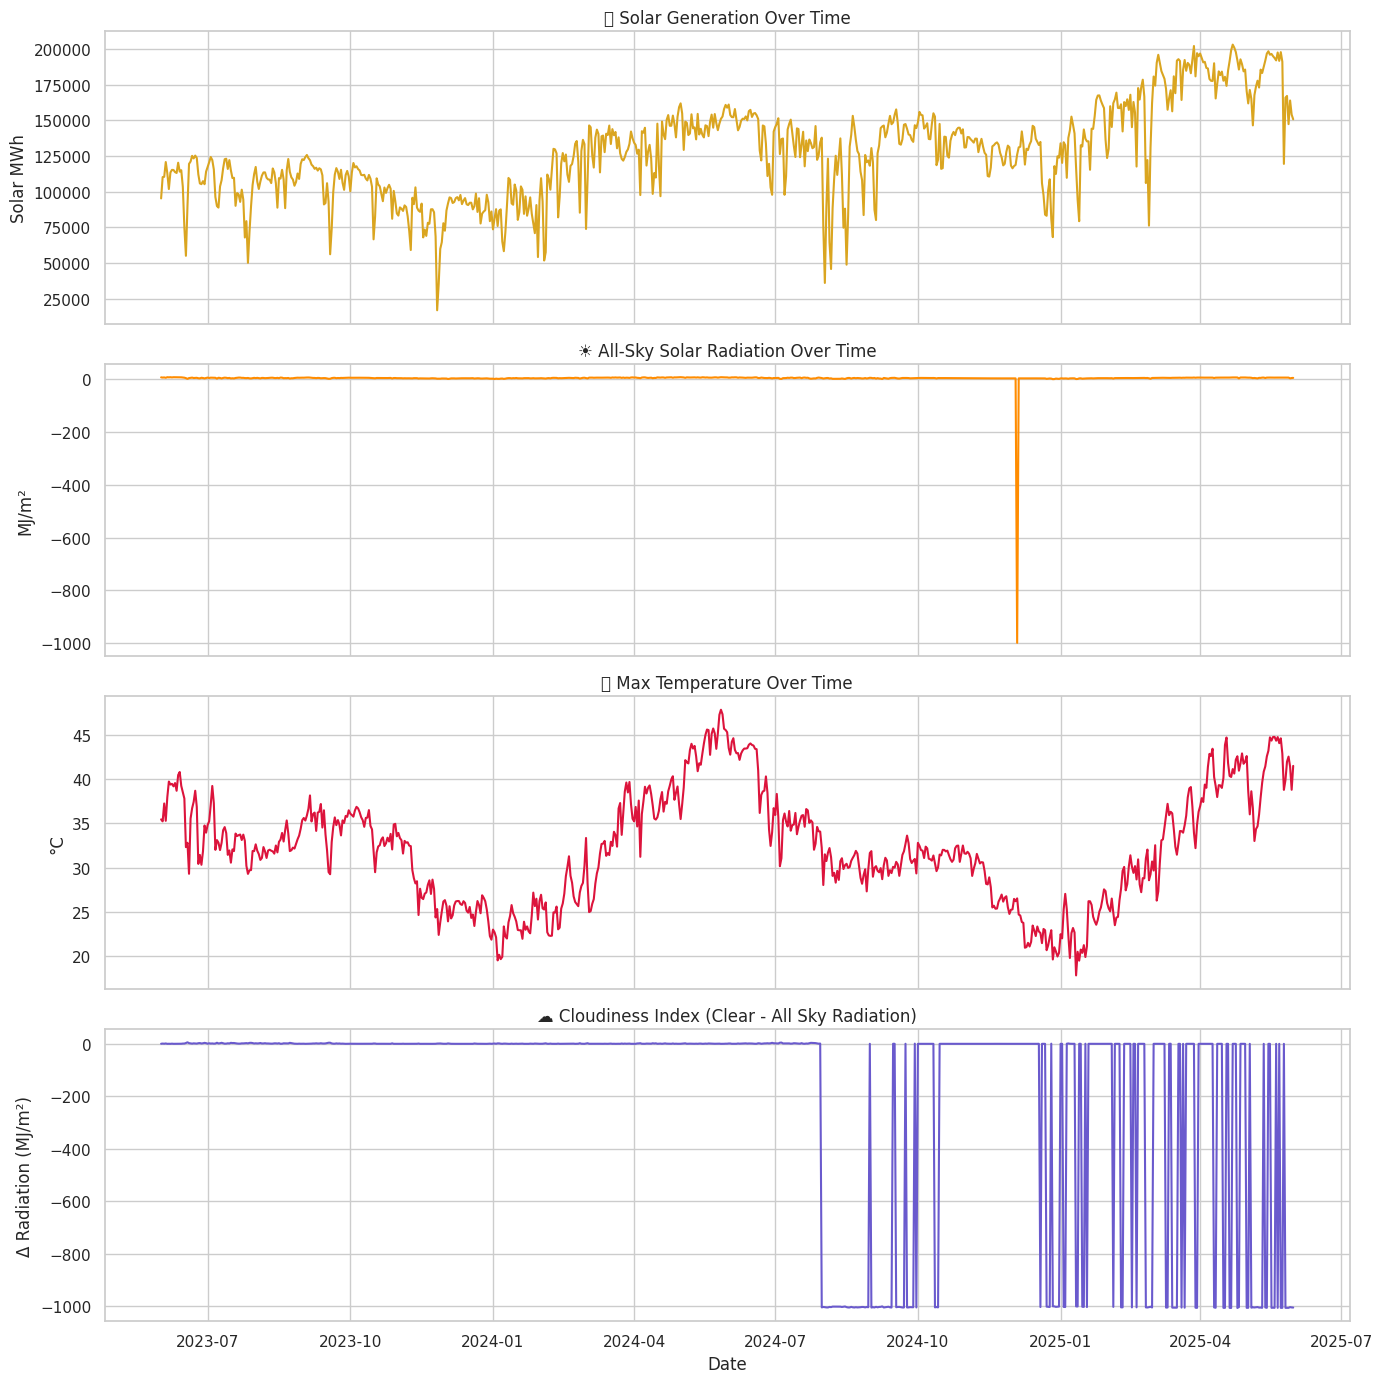

<Figure size 640x480 with 0 Axes>

In [77]:
# Set the plotting style
sns.set(style="whitegrid")

# Line plots over time
fig, axs = plt.subplots(4, 1, figsize=(14, 14), sharex=True)

# Plotting key variables over time
axs[0].plot(df['date'], df['solar_mwh'], label='Solar Generation (MWh)', color='goldenrod')
axs[0].set_ylabel('Solar MWh')
axs[0].set_title("📈 Solar Generation Over Time")

axs[1].plot(df['date'], df['solar_rad_allsky_mj_m2'], label='All-Sky Radiation', color='darkorange')
axs[1].set_ylabel('MJ/m²')
axs[1].set_title("☀️ All-Sky Solar Radiation Over Time")

axs[2].plot(df['date'], df['temp_max_c'], label='Max Temp (°C)', color='crimson')
axs[2].set_ylabel('°C')
axs[2].set_title("🌡️ Max Temperature Over Time")

axs[3].plot(df['date'], df['cloudiness_index'], label='Cloudiness Index', color='slateblue')
axs[3].set_ylabel('Δ Radiation (MJ/m²)')
axs[3].set_title("☁️ Cloudiness Index (Clear - All Sky Radiation)")

plt.xlabel("Date")
plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/DayAheadSolar/outputs/temporal.png', dpi=300, bbox_inches='tight')

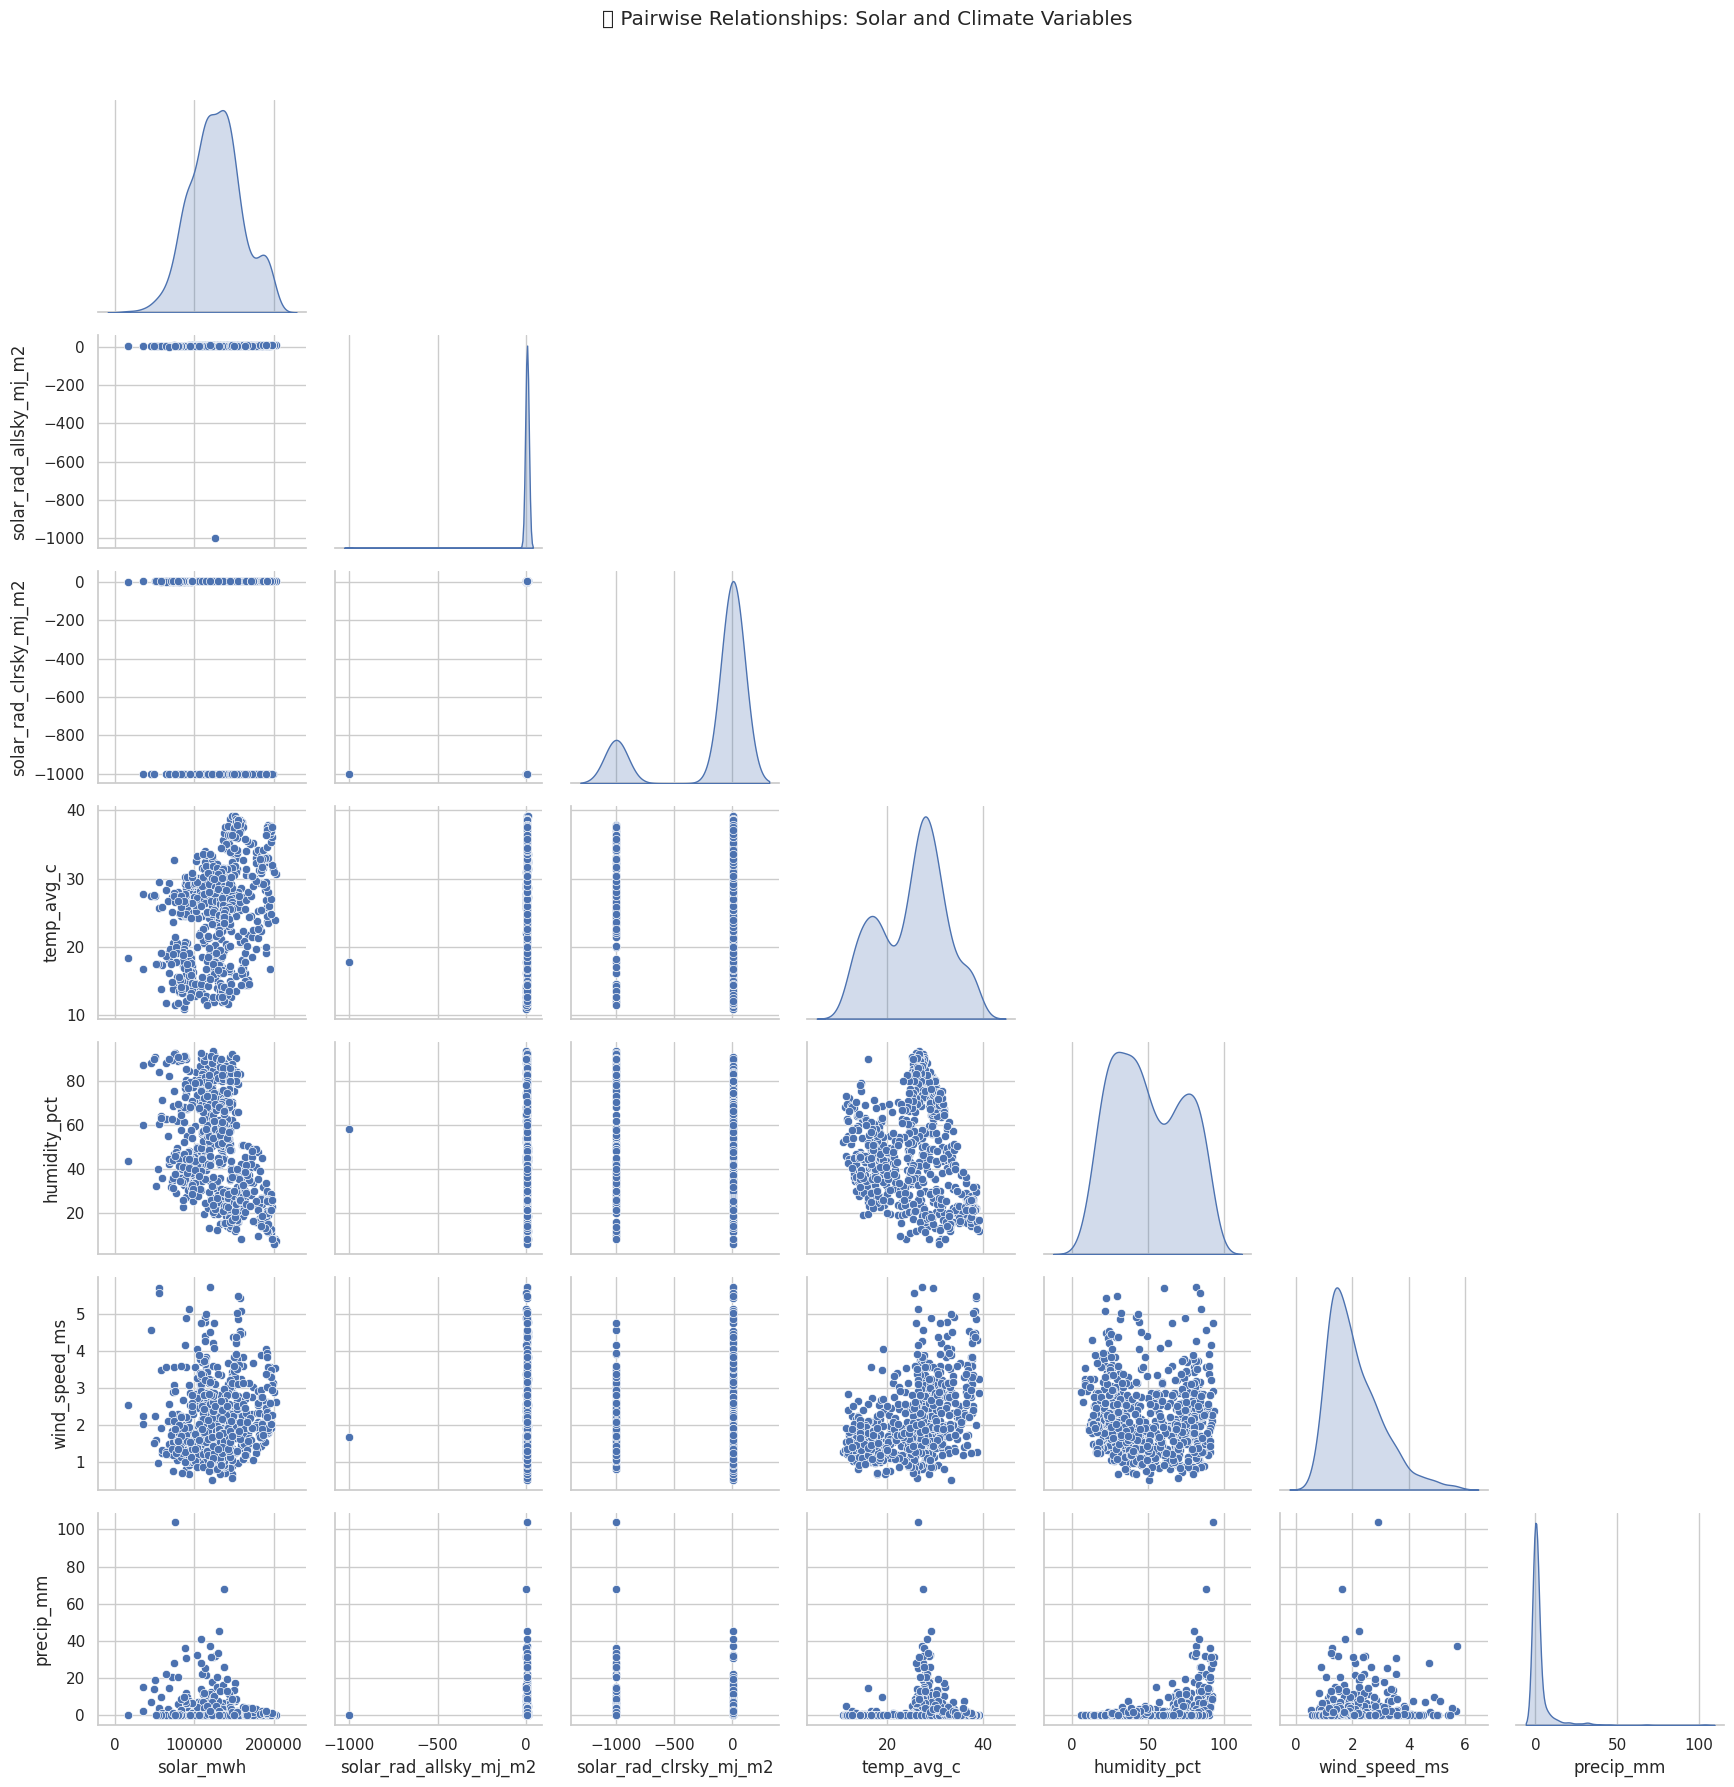

<Figure size 640x480 with 0 Axes>

In [78]:
# Select subset of variables for pairplot
pairplot_cols = [
    'solar_mwh',
    'solar_rad_allsky_mj_m2',
    'solar_rad_clrsky_mj_m2',
    'temp_avg_c',
    'humidity_pct',
    'wind_speed_ms',
    'precip_mm'
]

# Generate pairplot
sns.pairplot(df[pairplot_cols], diag_kind='kde', corner=True)
plt.suptitle("🧩 Pairwise Relationships: Solar and Climate Variables", y=1.02)
plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/DayAheadSolar/outputs/pairplot.png', dpi=300, bbox_inches='tight')

In [ ]:
# ✅ Feature Engineering
# Create lag and rolling mean features
lags = [1, 7]   # days
rolling_window = 7  # days

# Columns to create features for
features = [
    'solar_mwh', 'temp_avg_c', 'humidity_pct', 'wind_speed_ms', 'solar_rad_allsky_mj_m2'
]

for col in features:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)
    df[f'{col}_rollmean{rolling_window}'] = df[col].rolling(window=rolling_window).mean()

# Save engineered dataset
output_path = "/content/drive/MyDrive/DayAheadSolar/data/processed/merged_solar_climate_engineered.csv"
df.to_csv(output_path, index=False)
print(f"✅ Feature-engineered dataset saved to: {output_path}")

✅ Feature-engineered dataset saved to: /content/drive/MyDrive/DayAheadSolar/data/processed/merged_solar_climate_engineered.csv


## Modelling Solar Output Predictions based on Climate Parameters

### Linear Regression, Random Forest, XGBoost, Neural Network

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
file_path = "/content/drive/MyDrive/DayAheadSolar/data/processed/merged_solar_climate.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

In [ ]:
df['cloudiness_index'] = df['solar_rad_clrsky_mj_m2'] - df['solar_rad_allsky_mj_m2']

In [ ]:
# Select features and target
features = ['temp_avg_c', 'temp_max_c', 'temp_min_c', 'humidity_pct',
            'wind_speed_ms', 'precip_mm', 'solar_rad_allsky_mj_m2',
            'solar_rad_clrsky_mj_m2', 'cloudiness_index']
target = 'solar_mwh'

X = df[features]
y = df[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# Model evaluation function
results = {}
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"\n📊 {name} Results:")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R^2:", r2)
    return y_pred

In [ ]:
# Split once for benchmarking
train_size = int(0.8 * len(df))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# 1. Linear Regression
lr = LinearRegression()
y_pred_lr = evaluate_model("Linear Regression", lr, X_train, X_test, y_train, y_test)


📊 Linear Regression Results:
MAE: 40862.04337577515
RMSE: 44857.359123549926
R^2: -2.120545129266705


In [ ]:
# 2. Random Forest with tuning
rfr = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
gs_rfr = GridSearchCV(rfr, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
gs_rfr.fit(X_train, y_train)
y_pred_rf = gs_rfr.predict(X_test)
evaluate_model("Random Forest", gs_rfr.best_estimator_, X_train, X_test, y_train, y_test)


📊 Random Forest Results:
MAE: 46038.29348387211
RMSE: 48754.07378800961
R^2: -2.6862508399731215


array([ 79288.60720317,  72772.43183021, 101065.02596446, 114326.3385763 ,
       107889.73747274, 103984.01934592, 108366.84450877, 113233.96714035,
       102942.66049347, 118618.69852814, 112216.93915332, 115740.36778427,
       101389.42408322, 123856.44536569, 119514.45428571, 122855.33545122,
       115723.18902517,  99846.71573598, 116953.86178571, 110116.78612743,
        98591.87514512,  99524.94523212, 105298.19200429,  96857.69480573,
        92483.91432279,  97748.89480398,  93557.87999427, 110974.38019569,
       106407.39689907, 116011.01578318, 123344.08137124, 110348.91952381,
       109949.9497619 , 113928.03619048, 116346.22611143, 115456.43400724,
       110012.598902  , 113041.15468286, 110632.26893187, 120720.21548872,
       113861.82331922, 116142.29568765, 111714.47608276, 108668.42598868,
       110759.42498589, 109832.37764255, 120013.72579749, 119665.94582929,
       123591.74      , 125374.81818182, 124903.08484848, 115094.72055366,
       124762.61522194,  

In [ ]:
# 3. XGBoost with tuning
xgb = XGBRegressor(random_state=42, verbosity=0)
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
gs_xgb = GridSearchCV(xgb, param_grid_xgb, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
gs_xgb.fit(X_train, y_train)
y_pred_xgb = gs_xgb.predict(X_test)
evaluate_model("XGBoost", gs_xgb.best_estimator_, X_train, X_test, y_train, y_test)


📊 XGBoost Results:
MAE: 47511.106664540814
RMSE: 50130.88854698899
R^2: -2.8973900193304654


array([ 87882.9  ,  83025.36 ,  98835.69 , 115645.96 , 112854.43 ,
       105062.54 , 104110.03 , 108919.695, 118237.65 , 107200.13 ,
       109040.1  , 112179.7  ,  97843.25 , 123616.664, 111832.67 ,
       111599.47 , 119505.57 ,  97831.46 , 110113.06 , 118508.5  ,
        97160.234, 102798.37 , 101818.6  , 100456.125,  98353.35 ,
       112193.25 ,  96982.57 , 103185.25 , 101811.67 , 115963.34 ,
       119436.78 , 115575.48 , 111124.11 , 115595.664, 110230.43 ,
       111853.234,  98701.3  , 114698.09 , 106523.67 , 119375.56 ,
       118427.664, 127249.29 , 115650.16 , 107870.36 , 118359.99 ,
        98844.13 , 112746.055, 115242.73 , 132493.8  , 129499.94 ,
       127952.39 , 119055.02 , 124838.96 ,  97454.945,  86382.79 ,
       130207.82 , 114088.74 , 126759.18 , 127326.14 , 126585.95 ,
       128750.53 , 129797.07 , 128661.9  , 129933.99 , 123361.88 ,
       118246.85 , 126985.984, 109288.12 , 113045.44 , 110040.4  ,
       117623.46 , 117158.82 , 128545.79 , 128178.98 , 115837.

In [ ]:
# 4. Neural Network (Keras)
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
nn.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
nn.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[es], verbose=0)
y_pred_nn = nn.predict(X_test).flatten()
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)
results["Neural Network"] = {"MAE": mae_nn, "RMSE": rmse_nn, "R2": r2_nn}
print("\n📊 Neural Network Results:")
print("MAE:", mae_nn)
print("RMSE:", rmse_nn)
print("R^2:", r2_nn)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

📊 Neural Network Results:
MAE: 134160.89570835658
RMSE: 137569.6500199391
R^2: -28.350015085340665


In [ ]:
# Show comparison table
results_df = pd.DataFrame(results).T.sort_values(by="RMSE")
print("\n🔍 Model Comparison:")
print(results_df)


🔍 Model Comparison:
                             MAE           RMSE         R2
Linear Regression   40862.043376   44857.359124  -2.120545
Random Forest       46038.293484   48754.073788  -2.686251
XGBoost             47511.106665   50130.888547  -2.897390
Neural Network     134160.895708  137569.650020 -28.350015


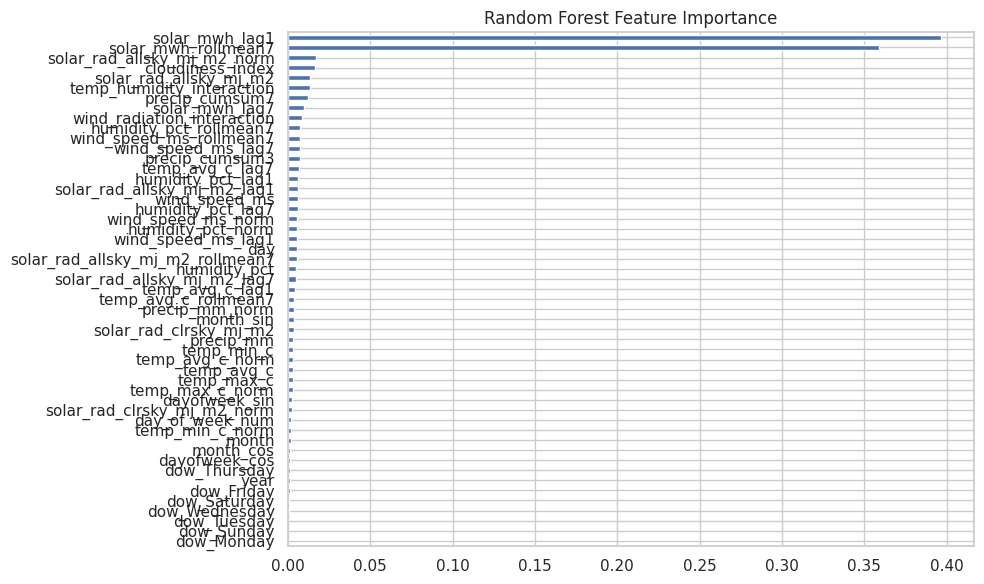

<Figure size 640x480 with 0 Axes>

In [79]:
# 🔍 Save feature importances (Random Forest)
rf_importance = pd.Series(gs_rfr.best_estimator_.feature_importances_, index=features)
rf_importance.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), title="Random Forest Feature Importance")
plt.tight_layout()
plt.show()

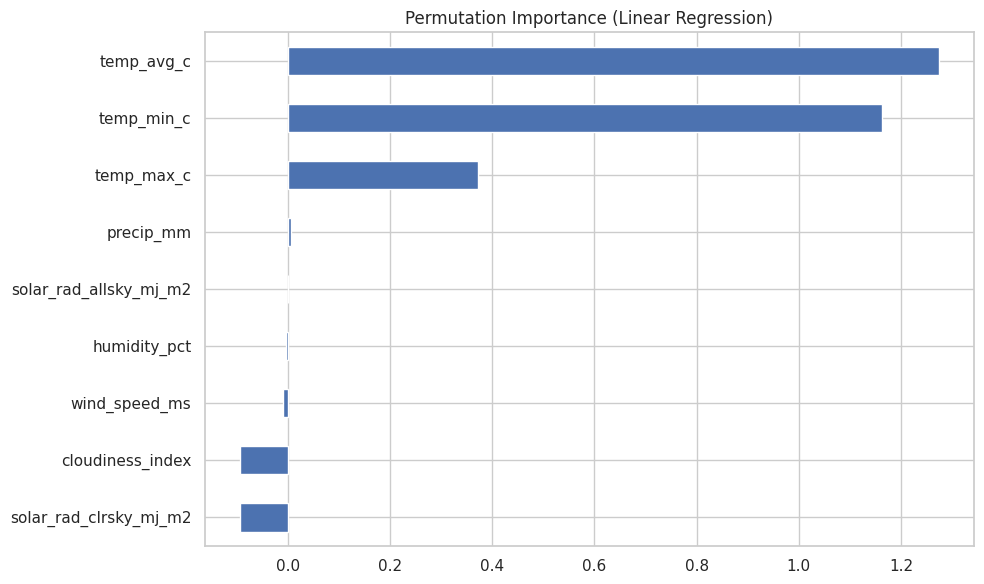

In [ ]:
# 🔍 Permutation importance for linear model
perm_importance = permutation_importance(lr, X_test, y_test, n_repeats=10, random_state=42)
perm_sorted = pd.Series(perm_importance.importances_mean, index=features).sort_values(ascending=True)
perm_sorted.plot(kind='barh', figsize=(10, 6), title="Permutation Importance (Linear Regression)")
plt.tight_layout()
plt.show()

## Re-training models after Feature Engineering

### Linear Regression, Random Forest, XGBoost, Neural Network

In [7]:
import pandas as pd
import numpy as np
import calendar
from sklearn.preprocessing import OneHotEncoder

# Load engineered data
file_path = "/content/drive/MyDrive/DayAheadSolar/data/processed/merged_solar_climate_engineered.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

# --- Encode day_of_week ---
df['day_of_week_num'] = df['date'].dt.dayofweek  # Monday=0

df = pd.get_dummies(df, columns=['day_of_week'], prefix='dow')

# --- Cyclical encoding ---
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['day_of_week_num'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['day_of_week_num'] / 7)

# --- Lag + rolling mean of target ---
df['solar_mwh_lag1'] = df['solar_mwh'].shift(1)
df['solar_mwh_lag7'] = df['solar_mwh'].shift(7)
df['solar_mwh_rollmean7'] = df['solar_mwh'].rolling(window=7).mean()

# --- Cumulative precipitation ---
df['precip_cumsum3'] = df['precip_mm'].rolling(window=3).sum()
df['precip_cumsum7'] = df['precip_mm'].rolling(window=7).sum()

# --- Interaction terms ---
df['temp_humidity_interaction'] = df['temp_avg_c'] * df['humidity_pct']
df['wind_radiation_interaction'] = df['wind_speed_ms'] * df['solar_rad_allsky_mj_m2']

# --- Save updated file ---
df.to_csv(file_path, index=False)
print(f"✅ Updated dataset with advanced features saved to: {file_path}")

✅ Updated dataset with advanced features saved to: /content/drive/MyDrive/DayAheadSolar/data/processed/merged_solar_climate_engineered.csv


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
file_path = "/content/drive/MyDrive/DayAheadSolar/data/processed/merged_solar_climate_engineered.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

In [11]:
# Drop NA rows from rolling and lag features
df = df.dropna().reset_index(drop=True)

# Target column
target = 'solar_mwh'

# Select all feature columns excluding date and target
drop_cols = ['date', 'solar_mwh', 'day_of_week']  # 'day_of_week' already one-hot encoded / cyclically encoded
features = [col for col in df.columns if col not in drop_cols]

X = df[features]
y = df[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data for training (time-based)
train_size = int(0.8 * len(df))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [12]:
# Evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R^2:", r2_score(y_test, y_pred))
    return y_pred

In [13]:
# 🔹 Linear Regression
print("\n🔹 Linear Regression")
lr = LinearRegression()
y_pred_lr = evaluate_model(lr, X_train, X_test, y_train, y_test)


🔹 Linear Regression
MAE: 10069.339139178925
RMSE: 14561.181447737117
R^2: 0.6600620420989891


In [14]:
# 🔹 Random Forest with GridSearchCV
print("\n🔹 Random Forest with GridSearchCV")
rfr = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
gs_rfr = GridSearchCV(rfr, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
gs_rfr.fit(X_train, y_train)
y_pred_rf = gs_rfr.predict(X_test)
print("Best Params:", gs_rfr.best_params_)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))


🔹 Random Forest with GridSearchCV
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
RMSE: 32505.076795360383


In [15]:
# 🔹 XGBoost with tuning
print("\n🔹 XGBoost")
xgb = XGBRegressor(random_state=42, verbosity=0)
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
gs_xgb = GridSearchCV(xgb, param_grid_xgb, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
gs_xgb.fit(X_train, y_train)
y_pred_xgb = gs_xgb.predict(X_test)
print("Best Params:", gs_xgb.best_params_)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))


🔹 XGBoost
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
RMSE: 34344.39471601141


In [16]:
# 🔹 Neural Network (Keras)
print("\n🔹 Neural Network")
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
nn.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
nn.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[es], verbose=0)
y_pred_nn = nn.predict(X_test).flatten()
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_nn)))


🔹 Neural Network


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
RMSE: 125441.21547795864


In [17]:
# 📊 Comparison Summary Table
results_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost", "Neural Network"],
    "MAE": [mean_absolute_error(y_test, y_pred_lr),
            mean_absolute_error(y_test, y_pred_rf),
            mean_absolute_error(y_test, y_pred_xgb),
            mean_absolute_error(y_test, y_pred_nn)],
    "RMSE": [np.sqrt(mean_squared_error(y_test, y_pred_lr)),
             np.sqrt(mean_squared_error(y_test, y_pred_rf)),
             np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
             np.sqrt(mean_squared_error(y_test, y_pred_nn))],
    "R2": [r2_score(y_test, y_pred_lr),
           r2_score(y_test, y_pred_rf),
           r2_score(y_test, y_pred_xgb),
           r2_score(y_test, y_pred_nn)]
})

print("\n🔍 Model Comparison:")
print(results_df)


🔍 Model Comparison:
               Model            MAE           RMSE         R2
0  Linear Regression   10069.339139   14561.181448   0.660062
1      Random Forest   29389.648276   32505.076795  -0.693982
2            XGBoost   31179.585991   34344.394716  -0.891116
3     Neural Network  120861.221294  125441.215478 -24.228239


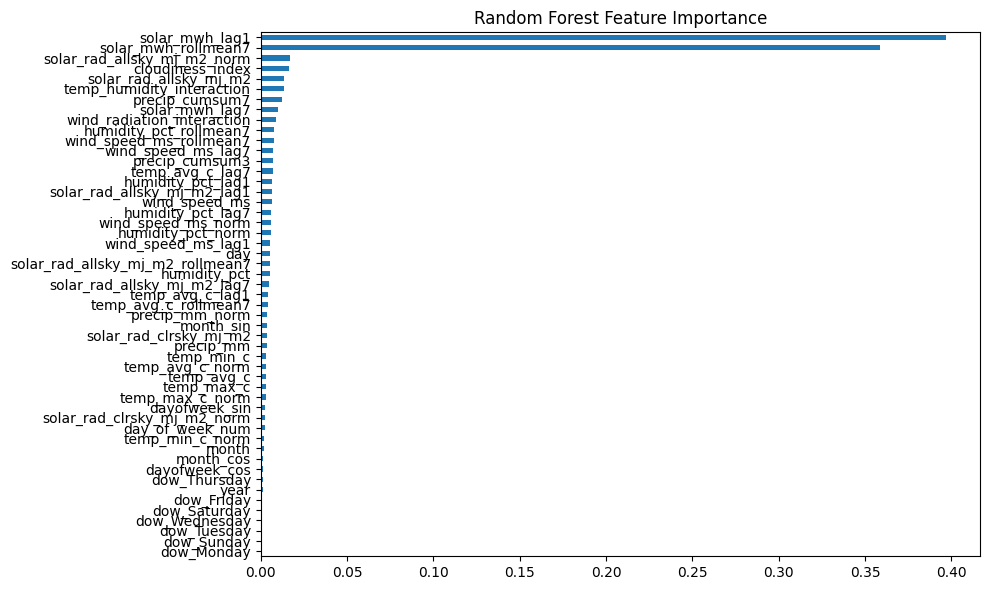

In [18]:
# 🔍 Feature Importance from RF
rf_importance = pd.Series(gs_rfr.best_estimator_.feature_importances_, index=features)
rf_importance.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), title="Random Forest Feature Importance")
plt.tight_layout()
plt.show()

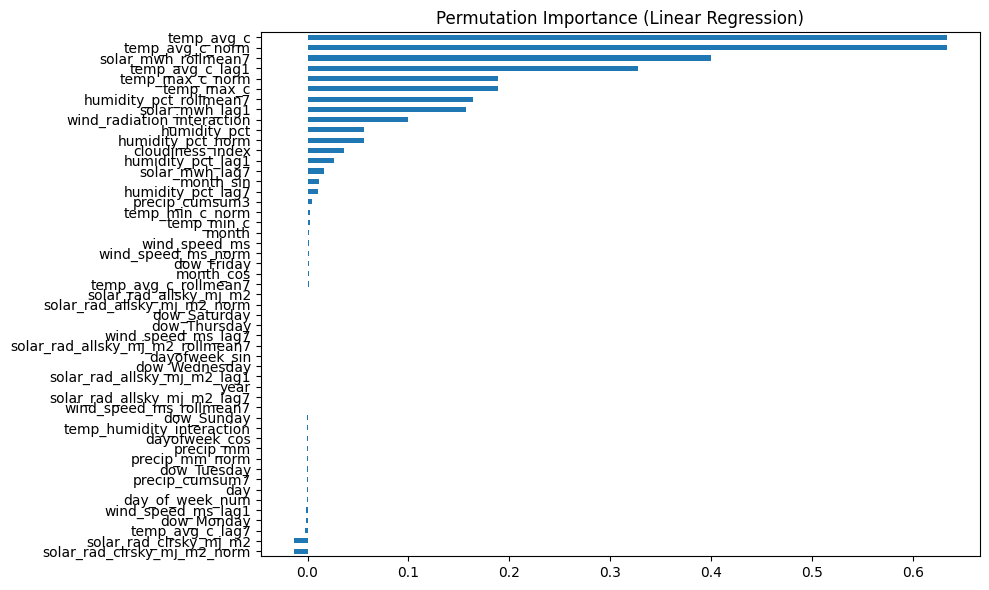

In [19]:
# 🔍 Permutation Importance from Linear Model
perm_importance = permutation_importance(lr, X_test, y_test, n_repeats=10, random_state=42)
perm_sorted = pd.Series(perm_importance.importances_mean, index=features).sort_values(ascending=True)
perm_sorted.plot(kind='barh', figsize=(10, 6), title="Permutation Importance (Linear Regression)")
plt.tight_layout()
plt.show()

## Time Series Models for Forecasting

### Prophet

In [81]:
import pandas as pd
from prophet import Prophet  # use 'from fbprophet import Prophet' if using older version

In [82]:
file_path = "/content/drive/MyDrive/DayAheadSolar/data/processed/merged_solar_climate_engineered.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

In [83]:
# Prophet requires columns 'ds' and 'y'
df_prophet = df[['date', 'solar_mwh']].rename(columns={'date': 'ds', 'solar_mwh': 'y'})

In [84]:
model = Prophet()
model.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeogzwsv8/m7rwq46l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeogzwsv8/1kx1n2dy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7405', 'data', 'file=/tmp/tmpeogzwsv8/m7rwq46l.json', 'init=/tmp/tmpeogzwsv8/1kx1n2dy.json', 'output', 'file=/tmp/tmpeogzwsv8/prophet_modelkwsb0vbo/prophet_model-20250619184913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [85]:
# Forecast the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

In [86]:
# Merge actuals with predictions
df_merged = df_prophet.merge(forecast[['ds', 'yhat']], on='ds', how='left')
true = df_merged['y']
pred = df_merged['yhat']

In [87]:
# Evaluation metrics
mae = mean_absolute_error(true, pred)
rmse = np.sqrt(mean_squared_error(true, pred))
r2 = r2_score(true, pred)

In [88]:
print("🔍 Prophet Model Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

🔍 Prophet Model Evaluation:
MAE: 12171.19
RMSE: 16647.93
R²: 0.7350


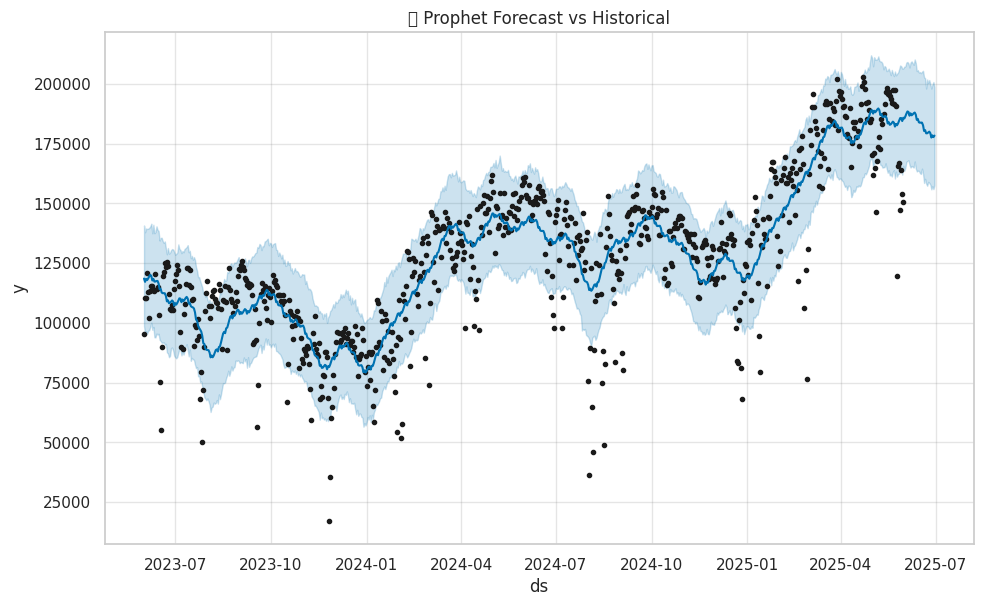

<Figure size 640x480 with 0 Axes>

In [89]:
# Plot forecast
model.plot(forecast)
plt.title("🔮 Prophet Forecast vs Historical")
plt.show()
plt.savefig('/content/drive/MyDrive/DayAheadSolar/outputs/prophet.png', dpi=300, bbox_inches='tight')

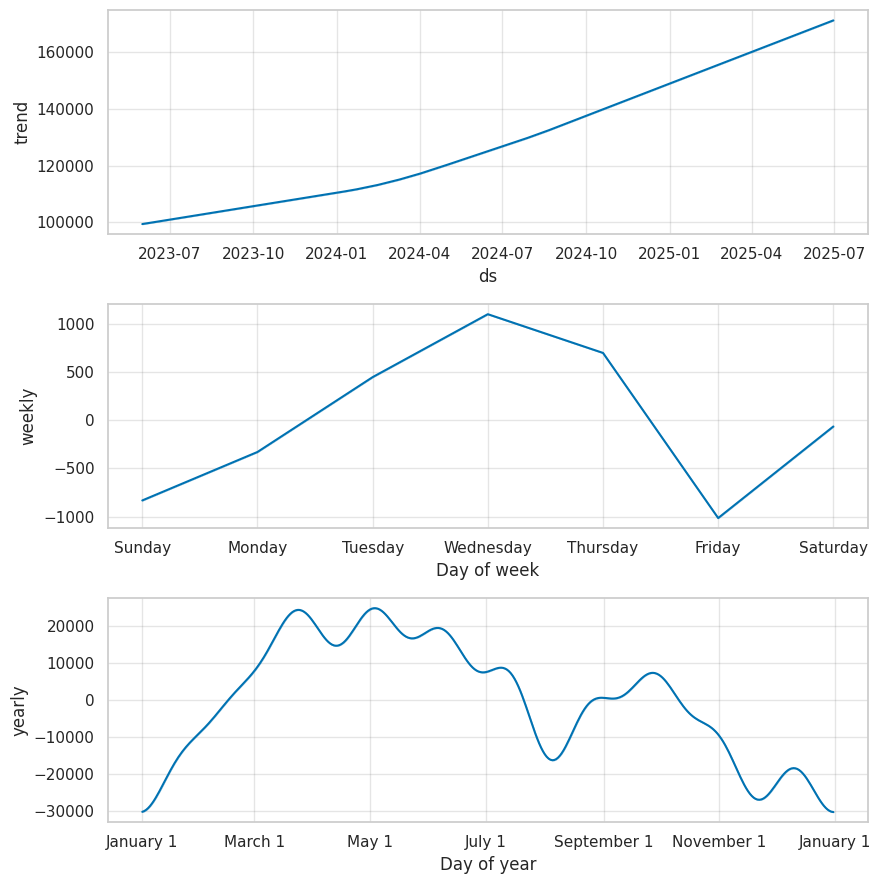

<Figure size 640x480 with 0 Axes>

In [90]:
# Plot forecast components
model.plot_components(forecast)
plt.show()
plt.savefig('/content/drive/MyDrive/DayAheadSolar/outputs/prophet_components.png', dpi=300, bbox_inches='tight')

Prophet outperforms all models except Linear Regression — and is very close to it.

### SARIMA

In [40]:
import pandas as pd

# Load the engineered dataset again for SARIMA preparation
file_path = f"{BASE}/data/processed/merged_solar_climate_engineered.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

# Keep only date and target variable for SARIMA
sarima_df = df[['date', 'solar_mwh']].set_index('date').asfreq('D')

# Display first few rows
sarima_df.head()

,solar_mwh
date,
2023-06-01,95310.0
2023-06-02,110250.0
2023-06-03,110430.0
2023-06-04,120770.0
2023-06-05,112970.0


In [41]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [42]:
# Split data into train/test (80/20 split)
train_size = int(len(sarima_df) * 0.8)
train, test = sarima_df.iloc[:train_size], sarima_df.iloc[train_size:]

In [43]:
# Fit SARIMA model (simple starting params: p,d,q)(P,D,Q,s)
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results = model.fit(disp=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
# Forecast
forecast = results.forecast(steps=len(test))

In [45]:
# Evaluate
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

In [46]:
print("🔍 SARIMA Model Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

🔍 SARIMA Model Evaluation:
MAE: 27255.91
RMSE: 31019.68
R²: -0.4922


/tmp/ipython-input-47-1653919338.py:10: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


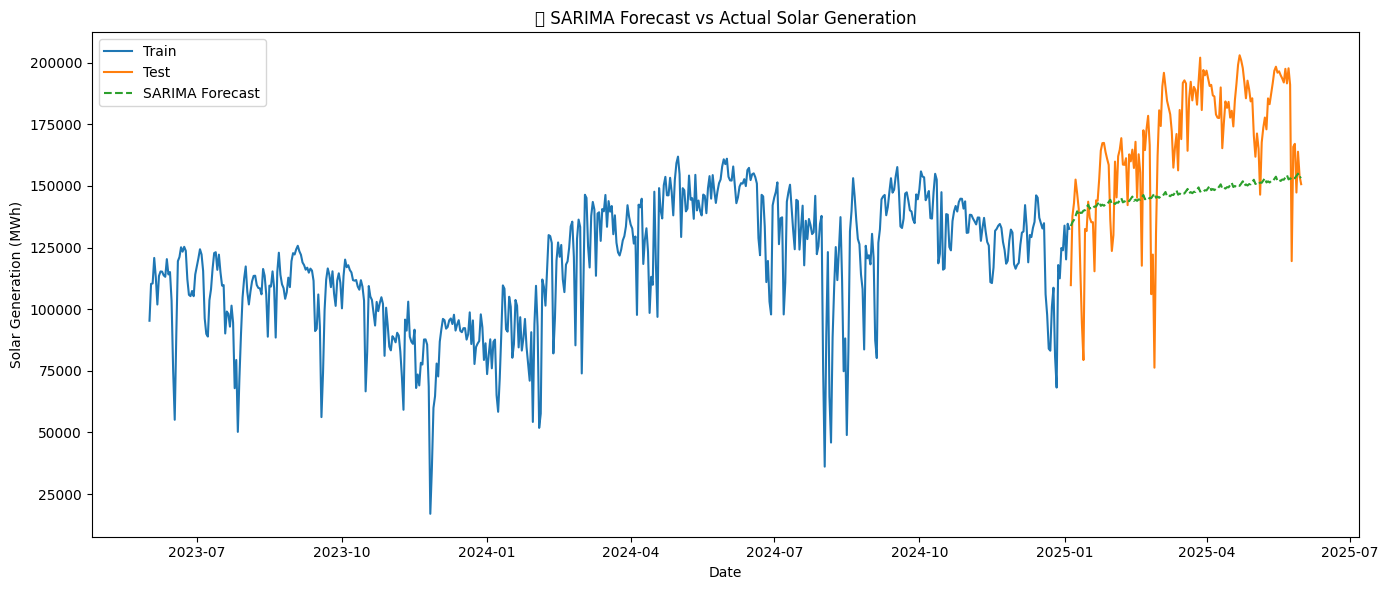

In [47]:
# Plot
plt.figure(figsize=(14,6))
plt.plot(train.index, train['solar_mwh'], label='Train')
plt.plot(test.index, test['solar_mwh'], label='Test')
plt.plot(test.index, forecast, label='SARIMA Forecast', linestyle='--')
plt.title("📈 SARIMA Forecast vs Actual Solar Generation")
plt.xlabel("Date")
plt.ylabel("Solar Generation (MWh)")
plt.legend()
plt.tight_layout()
plt.show()

### SARIMA with auto-tuning

In [62]:
# ✅ SARIMA Auto-Tuning on Solar Generation

import pandas as pd
import numpy as np
import itertools
import warnings
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings("ignore")

# Load dataset
file_path = "/content/drive/MyDrive/DayAheadSolar/data/processed/merged_solar_climate_engineered.csv"
df = pd.read_csv(file_path, parse_dates=['date'])
df = df[['date', 'solar_mwh']].dropna()
df = df.set_index('date')

# Train-test split
train_size = int(0.8 * len(df))
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Define SARIMA parameter grid
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 7  # Weekly seasonality

pdq = list(itertools.product(p, [1], q))
seasonal_pdq = list(itertools.product(P, [1], Q, [s]))

results = []

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            res = mod.fit(disp=False)
            pred = res.predict(start=test.index[0], end=test.index[-1], dynamic=False)

            mae = mean_absolute_error(test, pred)
            rmse = np.sqrt(mean_squared_error(test, pred))
            r2 = r2_score(test, pred)

            results.append({
                "order": param,
                "seasonal_order": seasonal_param,
                "MAE": round(mae, 2),
                "RMSE": round(rmse, 2),
                "R2": round(r2, 4)
            })
        except Exception as e:
            continue

# Convert to DataFrame
result_df = pd.DataFrame(results)
result_df = result_df.sort_values(by="RMSE")

print("Top 5 SARIMA Configurations (Lowest RMSE):")
print(result_df.head(5))

Top 5 SARIMA Configurations (Lowest RMSE):
        order seasonal_order       MAE      RMSE      R2
5   (0, 1, 1)   (0, 1, 1, 7)  29563.02  32948.78 -0.6836
9   (1, 1, 0)   (0, 1, 1, 7)  30885.68  34377.90 -0.8328
1   (0, 1, 0)   (0, 1, 1, 7)  32663.94  36266.34 -1.0397
11  (1, 1, 0)   (1, 1, 1, 7)  33909.47  37489.59 -1.1796
3   (0, 1, 0)   (1, 1, 1, 7)  34703.69  38335.54 -1.2791


### SARIMAX

In [50]:
import pandas as pd

# Load the engineered dataset again
file_path = f"{BASE}/data/processed/merged_solar_climate_engineered.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

# Sort by date and set date as index for time series modeling
df = df.sort_values("date").set_index("date")

# Check columns for exogenous variables
columns = df.columns.tolist()

In [51]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [52]:
# Define target and exogenous variables
target = df["solar_mwh"]
exog_vars = [
    'temp_avg_c', 'humidity_pct', 'wind_speed_ms',
    'solar_rad_allsky_mj_m2', 'cloudiness_index'
]

In [53]:
exog = df[exog_vars]

In [54]:
# Train/test split (80/20 split)
split = int(0.8 * len(df))
train_target, test_target = target.iloc[:split], target.iloc[split:]
train_exog, test_exog = exog.iloc[:split], exog.iloc[split:]

In [55]:
# Fit SARIMAX model
model = sm.tsa.SARIMAX(
    train_target,
    exog=train_exog,
    order=(1, 1, 1),        # You can tune these
    seasonal_order=(0, 1, 1, 7),  # Weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

In [56]:
results = model.fit(disp=False)

In [57]:
# Forecast
forecast = results.predict(start=split, end=len(df)-1, exog=test_exog)

In [58]:
# Evaluation
mae = mean_absolute_error(test_target, forecast)
rmse = np.sqrt(mean_squared_error(test_target, forecast))
r2 = r2_score(test_target, forecast)

In [59]:
print("🔍 SARIMAX Model Evaluation:")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")

🔍 SARIMAX Model Evaluation:
MAE: 40,903.73
RMSE: 45,100.52
R²: -2.1545


### SARIMAX with auto-tuning

In [67]:
# ✅ SARIMAX Auto-Tuned Forecast Plot & Residual Diagnostics

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools

# Load the engineered dataset
df = pd.read_csv(f"{BASE}/data/processed/merged_solar_climate_engineered.csv", parse_dates=["date"])

# Create cloudiness index if not already present
if 'cloudiness_index' not in df.columns:
    df['cloudiness_index'] = df['solar_rad_clrsky_mj_m2'] - df['solar_rad_allsky_mj_m2']

# Drop rows with missing values (from rolling, lags)
df.dropna(inplace=True)

# Define target and base exogenous features
target = df["solar_mwh"]
base_exog_vars = [
    'temp_avg_c', 'humidity_pct', 'wind_speed_ms',
    'solar_rad_allsky_mj_m2', 'cloudiness_index'
]

exog = df[base_exog_vars]

# Train/test split (80/20 split)
split = int(0.8 * len(df))
train_target, test_target = target.iloc[:split], target.iloc[split:]
train_exog, test_exog = exog.iloc[:split], exog.iloc[split:]

# Auto-tune SARIMAX: try multiple (p,d,q) and seasonal (P,D,Q,s)
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(0, 1, 1, 7)]  # Fixing weekly seasonality for now

best_score = float("inf")
best_cfg = None
best_result = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = sm.tsa.SARIMAX(train_target,
                                   exog=train_exog,
                                   order=param,
                                   seasonal_order=seasonal_param,
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
            results = model.fit(disp=False)
            forecast = results.predict(start=split, end=len(df)-1, exog=test_exog)

            rmse = np.sqrt(mean_squared_error(test_target, forecast))

            if rmse < best_score:
                best_score = rmse
                best_cfg = (param, seasonal_param)
                best_result = results
        except Exception:
            continue

# Use best_result to get evaluation metrics
forecast_best = best_result.predict(start=split, end=len(df)-1, exog=test_exog)
mae = mean_absolute_error(test_target, forecast_best)
rmse = np.sqrt(mean_squared_error(test_target, forecast_best))
r2 = r2_score(test_target, forecast_best)

# Residuals
residuals = best_result.resid

print("\n🔍 Best SARIMAX Model Evaluation:")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")
print(f"Best Order: {best_cfg[0]}, Best Seasonal Order: {best_cfg[1]}")


🔍 Best SARIMAX Model Evaluation:
MAE: 15,764.80
RMSE: 20,523.06
R²: 0.3247
Best Order: (1, 1, 0), Best Seasonal Order: (0, 1, 1, 7)


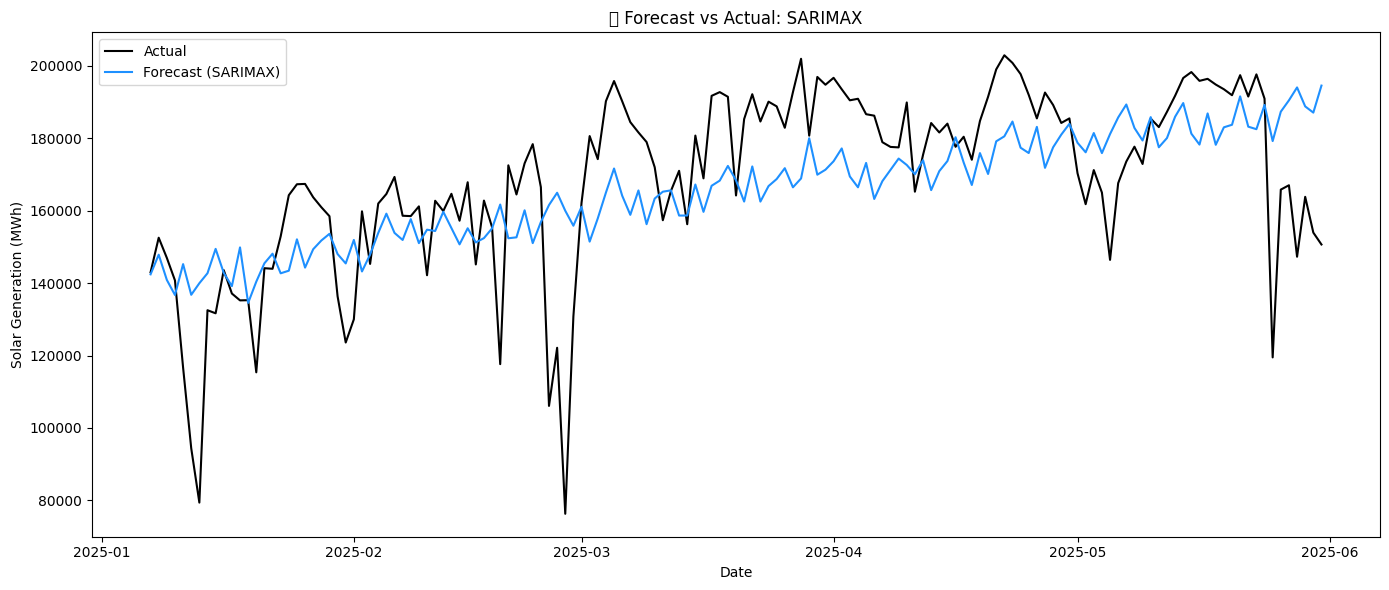

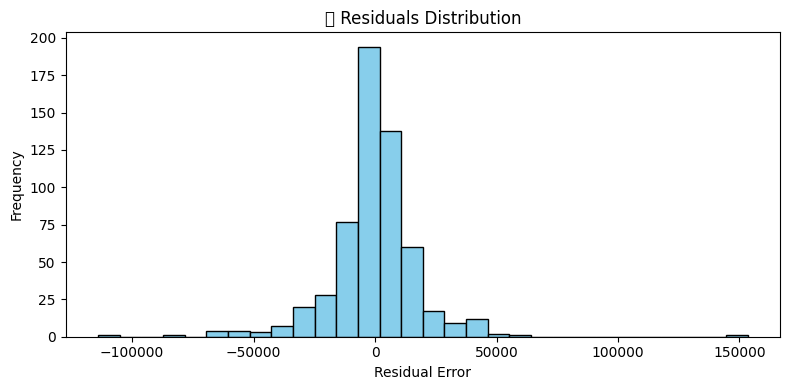

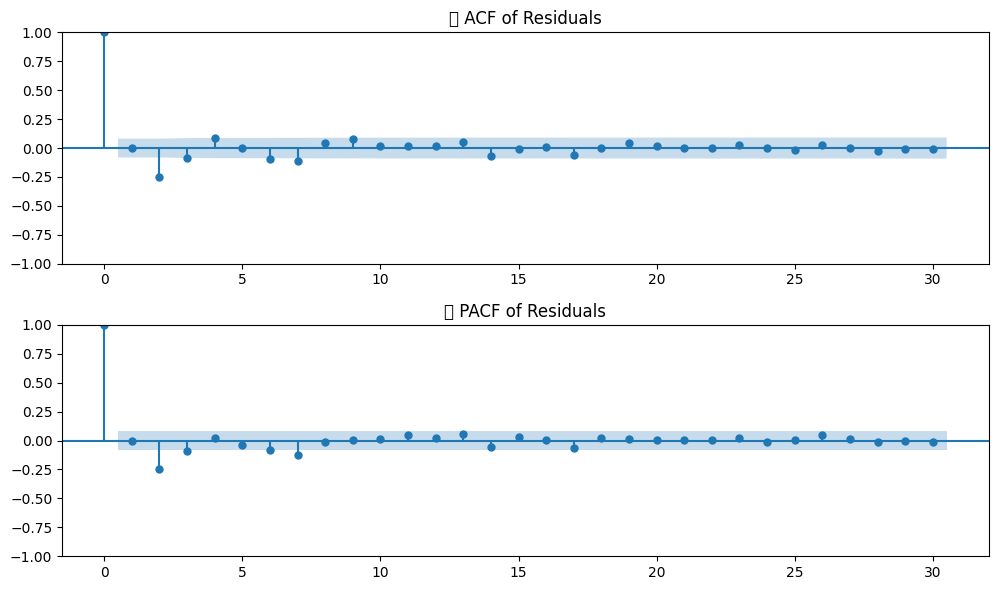

In [68]:
# 📈 Forecast vs Actual Plot
plt.figure(figsize=(14, 6))
plt.plot(df['date'].iloc[split:], test_target, label="Actual", color='black')
plt.plot(df['date'].iloc[split:], forecast_best, label="Forecast (SARIMAX)", color='dodgerblue')
plt.title("📈 Forecast vs Actual: SARIMAX")
plt.ylabel("Solar Generation (MWh)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Residuals Histogram
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("🔍 Residuals Distribution")
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 📉 ACF and PACF of Residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(residuals.dropna(), lags=30, ax=axs[0])
axs[0].set_title("📉 ACF of Residuals")
plot_pacf(residuals.dropna(), lags=30, ax=axs[1])
axs[1].set_title("📉 PACF of Residuals")
plt.tight_layout()
plt.show()

### SARIMAX with more exogenous variables

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load data
file_path = f"{BASE}/data/processed/merged_solar_climate_engineered.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

# Drop NA values due to lags/rolling
df = df.dropna().reset_index(drop=True)

# Set date index for SARIMAX
df.set_index('date', inplace=True)

# Target and exogenous variables (now include lags/rolling)
target = 'solar_mwh'
exog_features = [
    'temp_avg_c', 'humidity_pct', 'wind_speed_ms',
    'solar_rad_allsky_mj_m2',
    'solar_mwh_lag1', 'solar_mwh_lag7', 'solar_mwh_rollmean7'
]

# Split data into train/test
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Fit SARIMAX with additional exogenous variables
model_exog = SARIMAX(
    train[target],
    exog=train[exog_features],
    order=(1, 1, 0),
    seasonal_order=(0, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast
forecast = model_exog.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=test[exog_features]
)

# Evaluation
mae = mean_absolute_error(test[target], forecast)
rmse = np.sqrt(mean_squared_error(test[target], forecast))
r2 = r2_score(test[target], forecast)

# Residuals
residuals = test[target] - forecast

(mae, rmse, r2, residuals.describe())

(17716.689827776238,
 np.float64(23010.59589040009),
 0.1510889929344762,
 count      145.000000
 mean    -11465.339299
 std      20019.931060
 min     -77530.770431
 25%     -22349.371162
 50%     -11310.320813
 75%       2094.743027
 max      52862.424963
 dtype: float64)

## Insights

MAE: 29310.22688577586
RMSE: 1041803287.3660624
R²: -0.6702910626578882


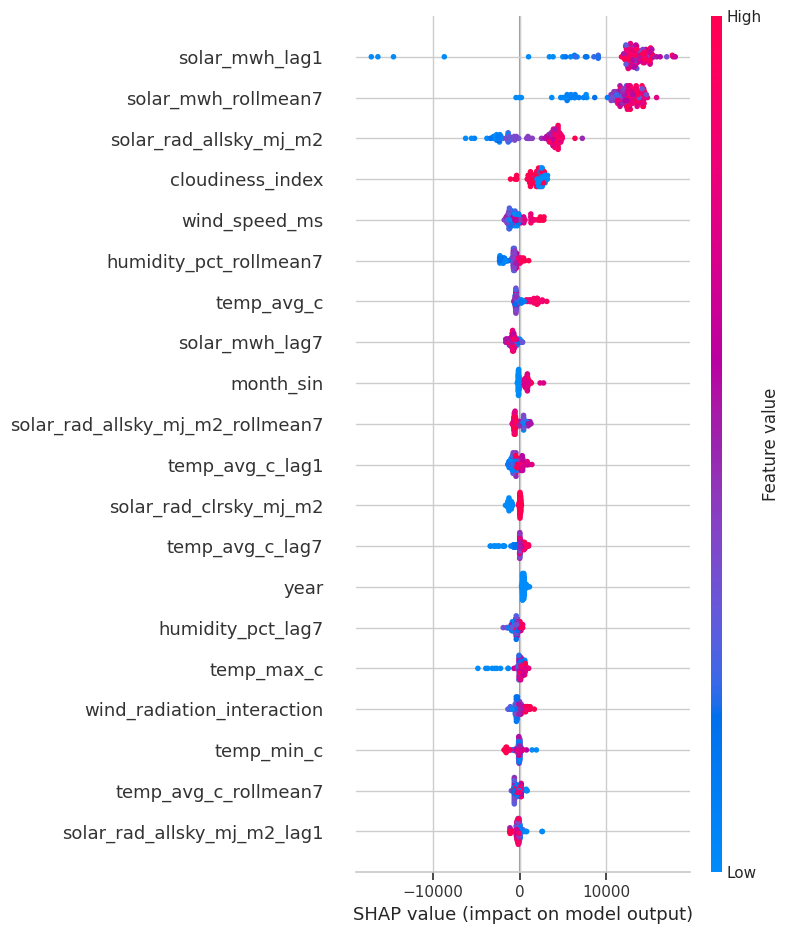

<Figure size 640x480 with 0 Axes>

In [91]:
# 📦 Required Libraries
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 📁 Load Data
df = pd.read_csv("/content/drive/MyDrive/DayAheadSolar/data/processed/merged_solar_climate_engineered.csv", parse_dates=["date"])

# 🧹 Clean + Setup
df.dropna(inplace=True)  # Drop rows with NA from rolling/lag
drop_cols = ["date", "day_of_week"]
target_col = "solar_mwh"
features = [col for col in df.columns if col not in drop_cols + [target_col]]

X = df[features]
y = df[target_col]

# 🧪 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# ⚙️ Train XGBoost Model
model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 🔍 Evaluate
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# 🔎 SHAP Explainability
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# 📊 SHAP Summary Plot
shap.summary_plot(shap_values, X_test)
plt.show()
plt.savefig('/content/drive/MyDrive/DayAheadSolar/outputs/shap.png', dpi=300, bbox_inches='tight')